# Approximation Interpretation

> In this notebook, I try to demonstrate an explanation for the approximation.

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
from collections import defaultdict
import gc
from pathlib import Path
from typing import Callable, Dict, List, Optional, Iterable, Sequence, Tuple

In [ ]:
#| hide
from fastcore.test import *
import math
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import seaborn as sns
import torch
from torch.nn import functional as F
from tqdm.auto import tqdm

In [ ]:
# | hide

from transformer_experiments.common.substring_generator import all_unique_substrings
from transformer_experiments.common.svd_helpers import projection_matrix_for_rank_k_approximation
from transformer_experiments.common.text_analysis import (
    build_next_token_map,
)
from transformer_experiments.dataset_split import split_text_dataset
from transformer_experiments.datasets.tinyshakespeare import (
    TinyShakespeareDataSet,
)
from transformer_experiments.environments import get_environment
from transformer_experiments.models.transformer import (
    block_size,
    n_embed,
    n_layer,
    TransformerLanguageModel
)
from transformer_experiments.models.transformer_helpers import (
    unsqueeze_emb,
    EncodingHelpers,
    LogitsWrapper,
    TransformerAccessors
)
from transformer_experiments.trained_models.tinyshakespeare_transformer import (
    create_model_and_tokenizer,
    FilenameForToken,
)
from transformer_experiments.experiments.cosine_sims import (
    filter_on_prefiltered_results,
)


## Preliminaries
Let's instantiate the model, grab the 20,000 strings we used to analyze the quality of the approximation, run them all through the model, and grab the feed-forward network outputs at each layer. 

In [ ]:
environment = get_environment()
print(f"environment is {environment.name}")

environment is local_mac


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ts = TinyShakespeareDataSet(cache_file=environment.code_root / 'nbs/artifacts/input.txt')
m, tokenizer = create_model_and_tokenizer(
    saved_model_filename=environment.code_root / 'nbs/artifacts/shakespeare-20231112.pt',
    dataset=ts,
    device=device,
)
_, val_data = split_text_dataset(ts.text, tokenizer, train_pct=0.9, device=device)
encoding_helpers = EncodingHelpers(tokenizer, device)
accessors = TransformerAccessors(m, device)

In [ ]:
# Get all the unique substrings of length 10 from the text
strings10 = all_unique_substrings(text=ts.text, substring_length=10)

In [ ]:
n_prompts = 20000

torch.manual_seed(1337)
indices = torch.randperm(len(strings10))[:n_prompts]
prompts = [strings10[i.item()] for i in indices]
prompts[:5]

['is dreams,', 'by present', 's eyes may', 'eart of ho', ' man, as I']

In [ ]:
# Tokenize the strings
tokens = encoding_helpers.tokenize_strings(prompts)

# Embed the tokens
accessors = TransformerAccessors(m, device)
embeddings = accessors.embed_tokens(tokens)

# Run them through the model with hooks attached that let us look at
# intermediate values
_, io_accessors = accessors.run_model(embeddings)

In [ ]:
# Grab the outputs of the ffwd networks at each layer
ffwd_outs = torch.stack([
    io_accessors[block_idx].output('ffwd')[:, -1, :].clone()
    for block_idx in range(n_layer)
])

ffwd_outs.shape

torch.Size([6, 20000, 384])

In [ ]:
# Free up some memory
del io_accessors
_ = gc.collect()

Now let's set ourselves up to find similar strings based on the pre-filtered cosine similarities.

In [ ]:
prefiltered_threshold=0.7
prefiltered_results_folder = environment.data_root / 'cosine_sim_results/large_files/slen10' / f'prefiltered_{prefiltered_threshold}'

def prefiltered_filename(block_idx: int, q_idx: int) -> Path:
    return prefiltered_results_folder / f'cosine_sim_ffwd_out_{q_idx:05d}_{block_idx:02d}.pt'

def load_prefiltered_data(block_idx: int, q_idx: int):
    return torch.load(prefiltered_filename(block_idx, q_idx))

In [ ]:
similarity_thresholds=[0.95, 0.94, 0.85, 0.76, 0.81, 0.89]

Lastly, let's define some basic building blocks we'll need.

In [ ]:
next_token_map10 = build_next_token_map(
    text=ts.text,
    prefix_len=10,
    vocab_size=tokenizer.vocab_size,
    stoi=tokenizer.stoi
)

In [ ]:
def hellinger_distance(
    p: torch.Tensor,
    q: torch.Tensor,
):
    return ((p.sqrt() - q.sqrt())**2).sum(dim=-1).sqrt() / math.sqrt(2)

In [ ]:
def plot_prob_distribution_for_tokens(
    prob_distribution: torch.Tensor,
    title: str = "",
    ax: Optional[Axes] = None,
    figsize=(12, 4),
):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    x_indices = np.arange(tokenizer.vocab_size)
    x_labels = [repr(c)[1:-1] for c in tokenizer.chars]

    ax.bar(x_indices, prob_distribution)
    ax.set_xticks(x_indices, x_labels, rotation="vertical")
    ax.set_title(title)
    ax.set_ylim(0.0, 1.0)

    return ax

## Hypothesis


Let's think about the transformer model from the end and go backwards. At the end of the sequence of blocks, the model has computed some value in embedding space. It then sends this through a final layer norm and then a final linear layer, which produces a value in logit space. The softmax operation at the very end transforms the logits into probabilities, one for each token. 

My hypothesis of what's going on is:

* There's a subspace of the whole embedding space that corresponds to each token being predicted. 
* The value computed by the feed forward network provides an "adjustment" to the input embedding that orients it towards the subspaces that correspond to the next token probabilities defined by the similar strings. 

## Approximating Token Subspaces

In [ ]:
def create_token_subspace_projection_matrices(
    subspace_dims: int,
    load_token_embeddings: Callable[[str], torch.Tensor],
    all_tokens: Sequence[str],
) -> torch.Tensor:
    """Returns a tensor of projection matrices that project onto
    the `subspace_dims`-dimensional space that approximates the
    subspace for each token. Returned tensor is of shape
    (vocab_size, n_embed, n_embed)."""

    return torch.stack([
        projection_matrix_for_rank_k_approximation(
            original_matrix=load_token_embeddings(token),
            k=subspace_dims,
        )
        for token in all_tokens
    ])

In [ ]:
def topk_similar_projections(
    token_subspace_projection_matrices: torch.Tensor,
    embedding: torch.Tensor,
    k: int,
    all_tokens: Sequence[str],
) -> Sequence[Tuple[str, float]]:
    """Projects `embedding` onto the subspaces for each token and then
    calculates the cosine similarity between the projected vector and
    `embedding`. Determines the top `k` most similar, and returns a
    sequence of tuples of the form (token, cosine_similarity)."""

    assert token_subspace_projection_matrices.ndim == 3
    assert token_subspace_projection_matrices.shape[1] == token_subspace_projection_matrices.shape[2]
    assert token_subspace_projection_matrices.shape[1] == embedding.shape[0]

    projections = token_subspace_projection_matrices @ embedding

    values, indices = torch.topk(
        F.cosine_similarity(projections, embedding, dim=-1),
        k=k,
        dim=0,
    )
    tokens = [all_tokens[i.item()] for i in indices]
    return list(zip(tokens, values.tolist()))

## Demonstrating the Hypothesis

### Setup

In [ ]:
learned_embeddings_dir = environment.data_root / 'learned_embeddings'
assert learned_embeddings_dir.exists(), "Learned embeddings directory doesn't exist. Run the code in experiments/learn-embeddings.ipynb to learn embeddings."

In [ ]:
filename_for_token = FilenameForToken(tokenizer)

In [ ]:
def perform_approximation(block_idx: int, q_idx: int) -> torch.Tensor:
    # Find similar strings
    similar_indices = filter_on_prefiltered_results(
        load_prefiltered=lambda q_idx: load_prefiltered_data(block_idx, q_idx),
        q_idx_start=q_idx,
        q_idx_end=q_idx+1,
        filter_fn=lambda values: values > similarity_thresholds[block_idx]
    )
    similar_strings = [
        [strings10[i] for i in indices]
        for indices in similar_indices
    ]

    # Compute Probability Distribution from Similar Strings
    total_freq_distribution = torch.stack(
        [next_token_map10[string] for string in similar_strings[0]]
    ).sum(dim=0)
    prob_distribution = total_freq_distribution / total_freq_distribution.sum()

    return prob_distribution, len(similar_strings[0])

In [ ]:
def perform_approximation_and_plot(block_idx: int, q_idx: int):
    prob_distribution, n_strings = perform_approximation(block_idx, q_idx)

    print(f"Found {n_strings} similar strings.")

    # Plot the probability distribution
    plot_prob_distribution_for_tokens(
        prob_distribution,
        title=f"Probability Distribution from Approximation (block_idx={block_idx}, q_idx={q_idx}, prompt={repr(prompts[q_idx])})",
    )

### Examples for the Final Output Head: Output Embedding --> Logits (No Blocks)

In [ ]:
no_blocks_proj_matrices = create_token_subspace_projection_matrices(
    subspace_dims=1,
    load_token_embeddings=lambda token: torch.load(
        learned_embeddings_dir /  'no_blocks' / f"{filename_for_token(token)}.pt",
        map_location=device,
    )[:, 0, :],
    all_tokens=tokenizer.chars
)
no_blocks_proj_matrices.shape

torch.Size([65, 384, 384])

Found 3 similar strings.


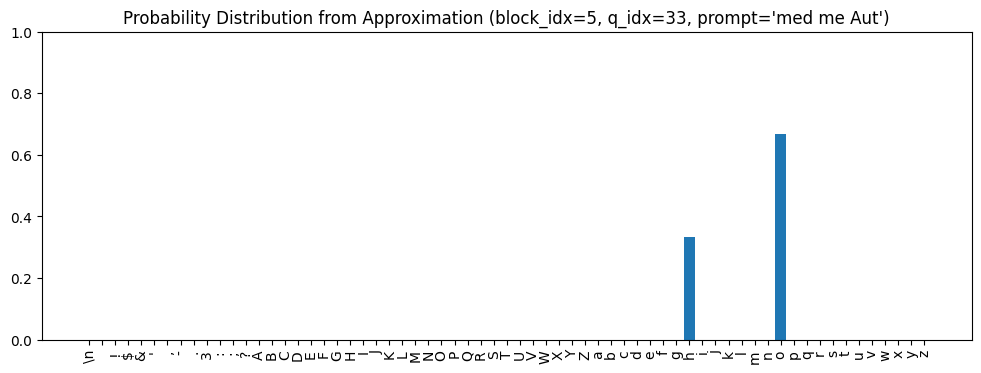

In [ ]:
block_idx = 5
q_idx = 33
perform_approximation_and_plot(block_idx, q_idx)

In [ ]:
topk_similar_projections(no_blocks_proj_matrices, ffwd_outs[block_idx, q_idx, :], k=5, all_tokens=tokenizer.chars)

[('o', 0.5074884295463562),
 ('h', 0.40787822008132935),
 ('i', 0.26926180720329285),
 ('u', 0.22823508083820343),
 ('y', 0.20325089991092682)]

Found 823 similar strings.


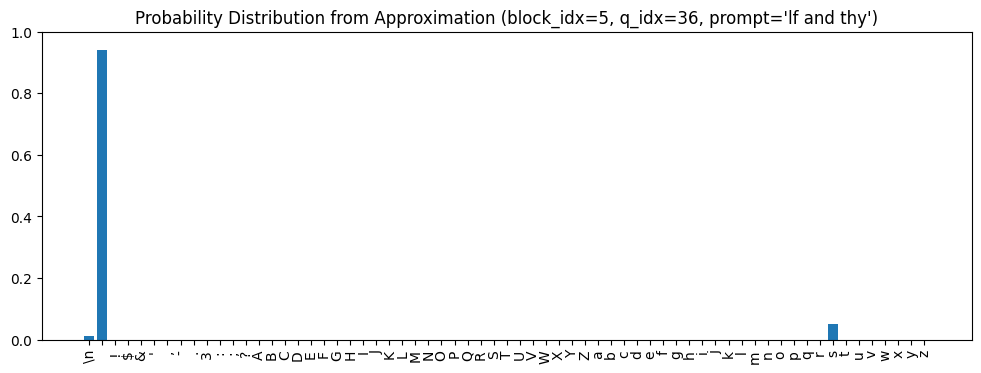

In [ ]:
block_idx = 5
q_idx = 36
perform_approximation_and_plot(block_idx, q_idx)

In [ ]:
topk_similar_projections(no_blocks_proj_matrices, ffwd_outs[block_idx, q_idx, :], k=5, all_tokens=tokenizer.chars)

[(' ', 0.5869003534317017),
 ('s', 0.47689366340637207),
 ('\n', 0.38412901759147644),
 ('$', 0.23048195242881775),
 ('a', 0.21783535182476044)]

### Examples with One Block: Block 5 --> Logits

In [ ]:
block_5_proj_matrices = create_token_subspace_projection_matrices(
    subspace_dims=1,
    load_token_embeddings=lambda token: torch.load(
        learned_embeddings_dir /  'block_5' / f"{filename_for_token(token)}.pt",
        map_location=device,
    )[:, 0, :],
    all_tokens=tokenizer.chars
)
block_5_proj_matrices.shape

torch.Size([65, 384, 384])

Found 3 similar strings.


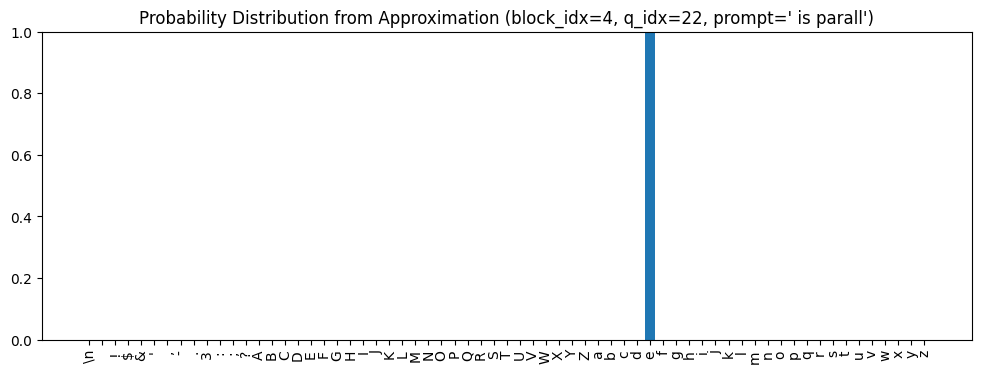

In [ ]:
block_idx = 4
q_idx = 22
perform_approximation_and_plot(block_idx, q_idx)

In [ ]:
topk_similar_projections(block_5_proj_matrices, ffwd_outs[block_idx, q_idx, :], k=5, all_tokens=tokenizer.chars)

[('e', 0.39072519540786743),
 ('t', 0.22815877199172974),
 ('w', 0.16565938293933868),
 ('O', 0.16220779716968536),
 ("'", 0.15983152389526367)]

Found 13 similar strings.


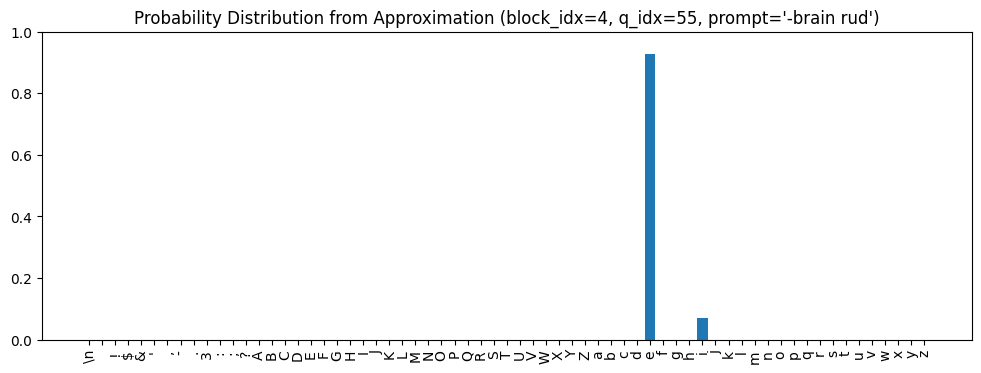

In [ ]:
block_idx = 4
q_idx = 55
perform_approximation_and_plot(block_idx, q_idx)

In [ ]:
topk_similar_projections(block_5_proj_matrices, ffwd_outs[block_idx, q_idx, :], k=5, all_tokens=tokenizer.chars)

[('e', 0.3601665794849396),
 ('l', 0.19291123747825623),
 ('O', 0.172983318567276),
 ('r', 0.15273427963256836),
 ('V', 0.14703969657421112)]

It doesn't work that well. 

What if we tried a higher dimensional approximation?

In [ ]:
topk_similar_projections(
    create_token_subspace_projection_matrices(
        subspace_dims=3,
        load_token_embeddings=lambda token: torch.load(
            learned_embeddings_dir /  'block_5' / f"{filename_for_token(token)}.pt",
            map_location=device,
        )[:, 0, :],
        all_tokens=tokenizer.chars
    ),
    ffwd_outs[block_idx, q_idx, :], k=5, all_tokens=tokenizer.chars
)

[('e', 0.3763144314289093),
 ('l', 0.21268059313297272),
 ('Q', 0.19100935757160187),
 ('r', 0.1881854087114334),
 ('p', 0.18020297586917877)]

Not much changed. What if we try sampling more embeddings, like 1000, instead of 100?

In [ ]:
topk_similar_projections(
    create_token_subspace_projection_matrices(
        subspace_dims=3,
        load_token_embeddings=lambda token: torch.load(
            learned_embeddings_dir /  'block_5_1000' / f"{filename_for_token(token)}.pt",
            map_location=device,
        )[:, 0, :],
        all_tokens=tokenizer.chars
    ),
    ffwd_outs[block_idx, q_idx, :], k=5, all_tokens=tokenizer.chars
)

[('e', 0.45469194650650024),
 ('l', 0.23989447951316833),
 ('r', 0.2296566665172577),
 ('Q', 0.22248920798301697),
 ('u', 0.18954990804195404)]

Not much changed. What if we try 5000?

In [ ]:
topk_similar_projections(
    create_token_subspace_projection_matrices(
        subspace_dims=3,
        load_token_embeddings=lambda token: torch.load(
            learned_embeddings_dir /  'block_5_5000' / f"{filename_for_token(token)}.pt",
            map_location=device,
        )[:, 0, :],
        all_tokens=tokenizer.chars
    ),
    ffwd_outs[block_idx, q_idx, :], k=5, all_tokens=tokenizer.chars
)

[('e', 0.4560593366622925),
 ('l', 0.2688257694244385),
 ('r', 0.2324495017528534),
 ('Q', 0.2060614824295044),
 ('b', 0.20078855752944946)]

### Examples with Two Blocks: Block 4 --> Logits

In [ ]:
block_4_proj_matrices = create_token_subspace_projection_matrices(
    subspace_dims=1,
    load_token_embeddings=lambda token: torch.load(
        learned_embeddings_dir /  'block_4' / f"{filename_for_token(token)}.pt",
        map_location=device,
    )[:, 0, :],
    all_tokens=tokenizer.chars
)
block_4_proj_matrices.shape

torch.Size([65, 384, 384])

Found 90 similar strings.


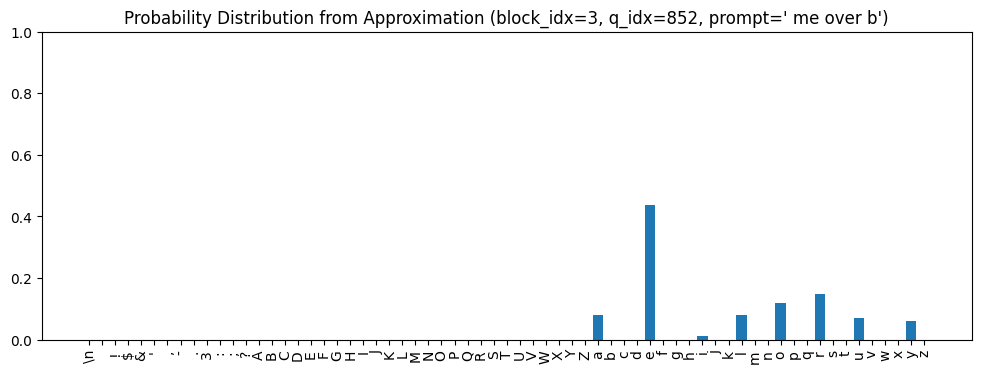

In [ ]:
block_idx = 3
q_idx = 852
perform_approximation_and_plot(block_idx, q_idx)

In [ ]:
topk_similar_projections(block_4_proj_matrices, ffwd_outs[block_idx, q_idx, :], k=5, all_tokens=tokenizer.chars)

[('n', 0.21810972690582275),
 ('R', 0.14459426701068878),
 ('c', 0.1221529021859169),
 ('G', 0.11818694323301315),
 ('U', 0.11376696825027466)]

## Aggregate Performance

### Implementation of the Metric

In [ ]:
def get_top_approximation_tokens_and_probs(
    block_idx: int,
    q_idx: int,
    prob_threshold=0.99,  # We'll include however many tokens needed to cover this much probability mass
):
    """Determine the tokens and their corresponding probabilities
    that cover `prob_threshold` probability mass in the distribution
    from the approximation based on similar strings."""
    distribution, _ = perform_approximation(block_idx, q_idx)

    # Find the number of tokens needed to cover `prob_threshold` probability mass
    sorted = distribution.sort(descending=True)
    n_tokens = (
        distribution.shape[0] - (sorted.values.cumsum(dim=0) > prob_threshold).sum() + 1
    )
    tokens = [tokenizer.itos[i.item()] for i in sorted.indices[:n_tokens]]
    probs = sorted.values[:n_tokens]
    return tokens, probs


def get_tokens_ordered_by_most_subspaces_similarity(
    embedding: torch.Tensor,
    token_subspace_projection_matrices: torch.Tensor,
) -> Sequence[str]:
    """Return the tokens ordered by the similarity of their token subspaces
    to the given embedding vector."""
    tokens, _ = zip(
        *topk_similar_projections(
            token_subspace_projection_matrices,
            embedding,
            k=tokenizer.vocab_size,
            all_tokens=tokenizer.chars,
        )
    )
    return tokens


def get_data_for_all_queries(
    block_idx: int,
    n_prompts: int,
    ffwd_outs: torch.Tensor,
    token_subspace_projection_matrices: torch.Tensor,
) -> Tuple[List[List[str]], List[List[float]], List[List[str]]]:
    approx_tokens = []
    approx_probs = []
    subspace_tokens = []
    for q_idx in tqdm(range(n_prompts)):
        tokens, probs = get_top_approximation_tokens_and_probs(block_idx, q_idx)
        approx_tokens.append(tokens)
        approx_probs.append(probs)

        subspace_tokens.append(
            get_tokens_ordered_by_most_subspaces_similarity(
                ffwd_outs[block_idx, q_idx, :],
                token_subspace_projection_matrices,
            )
        )

    return approx_tokens, approx_probs, subspace_tokens

def count_queries_satisfying_criteria(
    approx_tokens: List[List[str]],
    approx_probs: List[List[float]],
    subspace_tokens: List[List[str]],
    prob_threshold: float = 0.90,
    top_n: int = 5,
    n_subspaces: int = tokenizer.vocab_size // 2,
):
    assert len(approx_tokens) == len(approx_probs) == len(subspace_tokens)
    n_prompts = len(approx_tokens)

    count = 0
    for i in range(n_prompts):
        # Figure out how many tokens we need to look at to get to
        # `prob_threshold` cumulative probability.
        n_tokens = min(
            approx_probs[i].shape[0] - (approx_probs[i].cumsum(dim=0) > prob_threshold).sum() + 1,
            min(approx_probs[i].shape[0], top_n)
        )

        if all([approx_tokens[i][j] in subspace_tokens[i][:n_subspaces] for j in range(n_tokens)]):
            count += 1

    return count

In [ ]:
# Dict that will hold data per block_idx

per_block_data = defaultdict(lambda: {'approx_tokens': [], 'approx_probs': [], 'subspace_tokens': []})

### Output Embedding --> Logits (No Blocks)

In [ ]:
block_idx = 5
proj_matrices = no_blocks_proj_matrices
(
    per_block_data[block_idx]["approx_tokens"],
    per_block_data[block_idx]["approx_probs"],
    per_block_data[block_idx]["subspace_tokens"],
) = get_data_for_all_queries(
    block_idx=block_idx,
    n_prompts=n_prompts,
    ffwd_outs=ffwd_outs,
    token_subspace_projection_matrices=proj_matrices,
)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
block_idx = 5
prob_threshold = 0.90
top_n = 5
count = count_queries_satisfying_criteria(
    approx_tokens=per_block_data[block_idx]["approx_tokens"],
    approx_probs=per_block_data[block_idx]["approx_probs"],
    subspace_tokens=per_block_data[block_idx]["subspace_tokens"],
    prob_threshold=0.90,
    top_n=top_n,
    n_subspaces=tokenizer.vocab_size // 2,
)
print(f"{count:>5} ({count / n_prompts:.2%}) queries had {prob_threshold:.0%} of the predicted probability mass or top {top_n} tokens in the list of top token subspaces.")


17803 (89.02%) queries had 90% of the predicted probability mass or top 5 tokens in the list of top token subspaces.


### Block 5 --> Logits (1 Block)

In [ ]:
block_idx = 4
proj_matrices = block_5_proj_matrices
(
    per_block_data[block_idx]["approx_tokens"],
    per_block_data[block_idx]["approx_probs"],
    per_block_data[block_idx]["subspace_tokens"],
) = get_data_for_all_queries(
    block_idx=block_idx,
    n_prompts=n_prompts,
    ffwd_outs=ffwd_outs,
    token_subspace_projection_matrices=proj_matrices,
)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
block_idx = 4
prob_threshold = 0.90
top_n = 5
count = count_queries_satisfying_criteria(
    approx_tokens=per_block_data[block_idx]["approx_tokens"],
    approx_probs=per_block_data[block_idx]["approx_probs"],
    subspace_tokens=per_block_data[block_idx]["subspace_tokens"],
    prob_threshold=0.90,
    top_n=top_n,
    n_subspaces=tokenizer.vocab_size // 2,
)
print(f"{count:>5} ({count / n_prompts:.2%}) queries had {prob_threshold:.0%} of the predicted probability mass or top {top_n} tokens in the list of top token subspaces.")


10398 (51.99%) queries had 90% of the predicted probability mass or top 5 tokens in the list of top token subspaces.


### Block 4 --> Logits (2 Block)

In [ ]:
block_idx = 3
proj_matrices = block_4_proj_matrices
(
    per_block_data[block_idx]["approx_tokens"],
    per_block_data[block_idx]["approx_probs"],
    per_block_data[block_idx]["subspace_tokens"],
) = get_data_for_all_queries(
    block_idx=block_idx,
    n_prompts=n_prompts,
    ffwd_outs=ffwd_outs,
    token_subspace_projection_matrices=proj_matrices,
)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
block_idx = 3
prob_threshold = 0.90
top_n = 5
count = count_queries_satisfying_criteria(
    approx_tokens=per_block_data[block_idx]["approx_tokens"],
    approx_probs=per_block_data[block_idx]["approx_probs"],
    subspace_tokens=per_block_data[block_idx]["subspace_tokens"],
    prob_threshold=0.90,
    top_n=top_n,
    n_subspaces=tokenizer.vocab_size // 2,
)
print(f"{count:>5} ({count / n_prompts:.2%}) queries had {prob_threshold:.0%} of the predicted probability mass or top {top_n} tokens in the list of top token subspaces.")


 8131 (40.66%) queries had 90% of the predicted probability mass or top 5 tokens in the list of top token subspaces.


### What If We Always Use the Final Projection Matrices?

In [ ]:
alt_per_block_data = defaultdict(lambda: {'approx_tokens': [], 'approx_probs': [], 'subspace_tokens': []})

In [ ]:
block_idx = 4
proj_matrices = no_blocks_proj_matrices # This is actually the post block 5 projection matrices
(
    alt_per_block_data[block_idx]["approx_tokens"],
    alt_per_block_data[block_idx]["approx_probs"],
    alt_per_block_data[block_idx]["subspace_tokens"],
) = get_data_for_all_queries(
    block_idx=block_idx,
    n_prompts=n_prompts,
    ffwd_outs=ffwd_outs,
    token_subspace_projection_matrices=proj_matrices,
)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
block_idx = 4
prob_threshold = 0.90
top_n = 5
count = count_queries_satisfying_criteria(
    approx_tokens=alt_per_block_data[block_idx]["approx_tokens"],
    approx_probs=alt_per_block_data[block_idx]["approx_probs"],
    subspace_tokens=alt_per_block_data[block_idx]["subspace_tokens"],
    prob_threshold=0.90,
    top_n=top_n,
    n_subspaces=tokenizer.vocab_size // 2,
)
print(f"{count:>5} ({count / n_prompts:.2%}) queries had {prob_threshold:.0%} of the predicted probability mass or top {top_n} tokens in the list of top token subspaces.")


15512 (77.56%) queries had 90% of the predicted probability mass or top 5 tokens in the list of top token subspaces.


In [ ]:
block_idx = 3
proj_matrices = no_blocks_proj_matrices # This is actually the post block 5 projection matrices
(
    alt_per_block_data[block_idx]["approx_tokens"],
    alt_per_block_data[block_idx]["approx_probs"],
    alt_per_block_data[block_idx]["subspace_tokens"],
) = get_data_for_all_queries(
    block_idx=block_idx,
    n_prompts=n_prompts,
    ffwd_outs=ffwd_outs,
    token_subspace_projection_matrices=proj_matrices,
)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
block_idx = 3
prob_threshold = 0.90
top_n = 5
count = count_queries_satisfying_criteria(
    approx_tokens=alt_per_block_data[block_idx]["approx_tokens"],
    approx_probs=alt_per_block_data[block_idx]["approx_probs"],
    subspace_tokens=alt_per_block_data[block_idx]["subspace_tokens"],
    prob_threshold=0.90,
    top_n=top_n,
    n_subspaces=tokenizer.vocab_size // 2,
)
print(f"{count:>5} ({count / n_prompts:.2%}) queries had {prob_threshold:.0%} of the predicted probability mass or top {top_n} tokens in the list of top token subspaces.")

13252 (66.26%) queries had 90% of the predicted probability mass or top 5 tokens in the list of top token subspaces.


In [ ]:
block_idx = 2
proj_matrices = no_blocks_proj_matrices # This is actually the post block 5 projection matrices
(
    alt_per_block_data[block_idx]["approx_tokens"],
    alt_per_block_data[block_idx]["approx_probs"],
    alt_per_block_data[block_idx]["subspace_tokens"],
) = get_data_for_all_queries(
    block_idx=block_idx,
    n_prompts=n_prompts,
    ffwd_outs=ffwd_outs,
    token_subspace_projection_matrices=proj_matrices,
)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
block_idx = 2
prob_threshold = 0.90
top_n = 5
count = count_queries_satisfying_criteria(
    approx_tokens=alt_per_block_data[block_idx]["approx_tokens"],
    approx_probs=alt_per_block_data[block_idx]["approx_probs"],
    subspace_tokens=alt_per_block_data[block_idx]["subspace_tokens"],
    prob_threshold=0.90,
    top_n=top_n,
    n_subspaces=tokenizer.vocab_size // 2,
)
print(f"{count:>5} ({count / n_prompts:.2%}) queries had {prob_threshold:.0%} of the predicted probability mass or top {top_n} tokens in the list of top token subspaces.")

12861 (64.31%) queries had 90% of the predicted probability mass or top 5 tokens in the list of top token subspaces.


In [ ]:
block_idx = 1
proj_matrices = no_blocks_proj_matrices # This is actually the post block 5 projection matrices
(
    alt_per_block_data[block_idx]["approx_tokens"],
    alt_per_block_data[block_idx]["approx_probs"],
    alt_per_block_data[block_idx]["subspace_tokens"],
) = get_data_for_all_queries(
    block_idx=block_idx,
    n_prompts=n_prompts,
    ffwd_outs=ffwd_outs,
    token_subspace_projection_matrices=proj_matrices,
)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
block_idx = 1
prob_threshold = 0.90
top_n = 5
count = count_queries_satisfying_criteria(
    approx_tokens=alt_per_block_data[block_idx]["approx_tokens"],
    approx_probs=alt_per_block_data[block_idx]["approx_probs"],
    subspace_tokens=alt_per_block_data[block_idx]["subspace_tokens"],
    prob_threshold=0.90,
    top_n=top_n,
    n_subspaces=tokenizer.vocab_size // 2,
)
print(f"{count:>5} ({count / n_prompts:.2%}) queries had {prob_threshold:.0%} of the predicted probability mass or top {top_n} tokens in the list of top token subspaces.")

12007 (60.04%) queries had 90% of the predicted probability mass or top 5 tokens in the list of top token subspaces.


In [ ]:
block_idx = 0
proj_matrices = no_blocks_proj_matrices # This is actually the post block 5 projection matrices
(
    alt_per_block_data[block_idx]["approx_tokens"],
    alt_per_block_data[block_idx]["approx_probs"],
    alt_per_block_data[block_idx]["subspace_tokens"],
) = get_data_for_all_queries(
    block_idx=block_idx,
    n_prompts=n_prompts,
    ffwd_outs=ffwd_outs,
    token_subspace_projection_matrices=proj_matrices,
)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
block_idx = 0
prob_threshold = 0.90
top_n = 5
count = count_queries_satisfying_criteria(
    approx_tokens=alt_per_block_data[block_idx]["approx_tokens"],
    approx_probs=alt_per_block_data[block_idx]["approx_probs"],
    subspace_tokens=alt_per_block_data[block_idx]["subspace_tokens"],
    prob_threshold=0.90,
    top_n=top_n,
    n_subspaces=tokenizer.vocab_size // 2,
)
print(f"{count:>5} ({count / n_prompts:.2%}) queries had {prob_threshold:.0%} of the predicted probability mass or top {top_n} tokens in the list of top token subspaces.")

11625 (58.13%) queries had 90% of the predicted probability mass or top 5 tokens in the list of top token subspaces.


### Is This Better Than Chance?
To help understand whether or not the results above are meaningful, it's worth thinking about how easy it would be to satisfy our criteria by random chance. What if the similarities between the feed-forward network output and the token spaces were totally random, rather than related to the similar strings predictions. What percentage of the queries would still satisfy our criteria? 

Specifically, for a given query and a feed-forward output, what is the probability that `n` specific tokens are in the top `n_subspaces` entries of a randomly generated similarities tensor? 

If we can assume that each of the similarity values is independent and that they are distributed uniformly, then the probability that `n` tokens all appear in the top `n_subspaces` entries when ordered by value is simply:

$$
\frac{1}{\lfloor \frac{vocab\_size}{n\_subspaces} \rfloor^{n}}
$$

In the real data, the similarity values are probably not totally independent (because some subspaces may be closer together than others). But for the purposes of this exercise, I'm going to treat them as independent. 

But they are also definitely not uniformly distributed. By definition, cosine similarity can range between -1 and 1, but ours don't seem to seem to be uniform in that range. A random example:

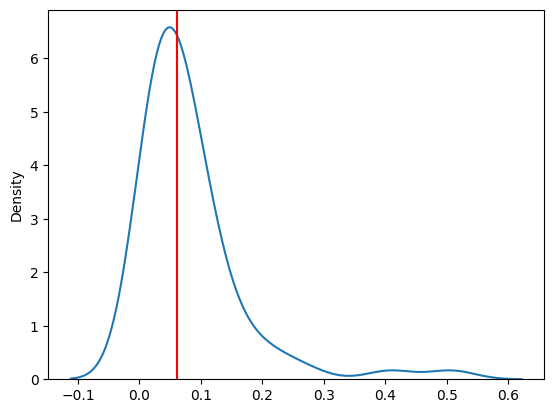

In [ ]:
block_idx = 5
q_idx = 33
sims = F.cosine_similarity(no_blocks_proj_matrices @ ffwd_outs[block_idx, q_idx, :], ffwd_outs[block_idx, q_idx, :], dim=-1)
sns.kdeplot(sims.cpu().numpy())
_ = plt.axvline(sims.median().item(), color='red')

We don't have an accurate mathematical description of the distribution of the real data so we can't say how the probability would precisely deviate from the formula above. But thankfully, we can estimate it empirically, via simulation. We can generate fake similarities with a similar distribution to the real data and then measure how often `n` selected tokens appear in the top `n_subspaces` entries over many iteratons.

First, let's define a helper to generate the similarities for all prompts for a given block:

In [ ]:
def compute_all_similarities_to_subspace_projections(
    block_idx: int,
    ffwd_outs: torch.Tensor,
    token_subspace_projection_matrices: torch.Tensor,
):
    """Returns a tensor of shape (n_prompts, vocab_size). The element
    at indices i, j is the cosine similarity between the ffwd output
    from `block_idx` for query i and the projection of that ffwd output
    onto the subspace for token j."""
    n_prompts = ffwd_outs.shape[1]

    embeddings = ffwd_outs[block_idx, :, :]
    all_sims = torch.stack(
        [
            F.cosine_similarity(
                token_subspace_projection_matrices @ embeddings[q_idx, :],
                embeddings[q_idx, :],
                dim=-1,
            )
            for q_idx in tqdm(range(n_prompts))
        ]
    )
    return all_sims

Now we run it on the block 5 data:

In [ ]:
block_idx = 5
proj_matrices = no_blocks_proj_matrices
block_5_sims = compute_all_similarities_to_subspace_projections(
    block_idx=block_idx,
    ffwd_outs=ffwd_outs,
    token_subspace_projection_matrices=proj_matrices,
)
block_5_sims.shape

  0%|          | 0/20000 [00:00<?, ?it/s]

torch.Size([20000, 65])

Let's look at the distribution across all the similarities (the previous plot just looked at one query):

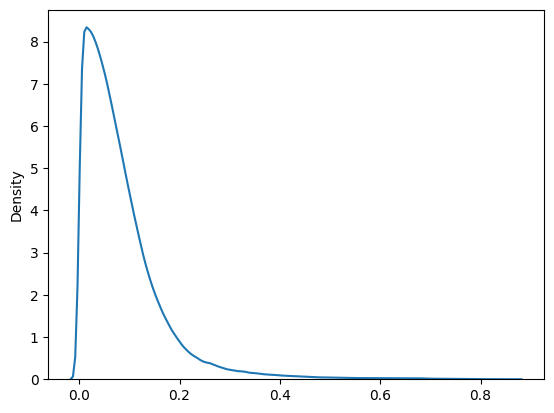

In [ ]:
_ = sns.kdeplot(block_5_sims.flatten(), label="real sims")

Next, we need something to generate random numbers with the same distribution. The helper below returns a function that samples from the KDE of the original data:

In [ ]:
def create_fake_sims_generator(
    reference_sims: torch.Tensor,
) -> Callable[[int], torch.Tensor]:
    """Returns a function that will generate fake similarities
    with roughly the same distribution as reference_sims."""
    kde = gaussian_kde(reference_sims)
    def fake_sims_generator(n: int):
        return torch.from_numpy(kde.resample(n).squeeze()).to(reference_sims.dtype)
    return fake_sims_generator

It produces fake data with the right distribution:

In [ ]:
# Show that the fake sims generator produces sims with roughly the same distribution
# as the real sims.
fake_sims_generator = create_fake_sims_generator(block_5_sims.flatten())

np.random.seed(123412) # Keep outputs stable
fake_sims = fake_sims_generator(block_5_sims.numel())

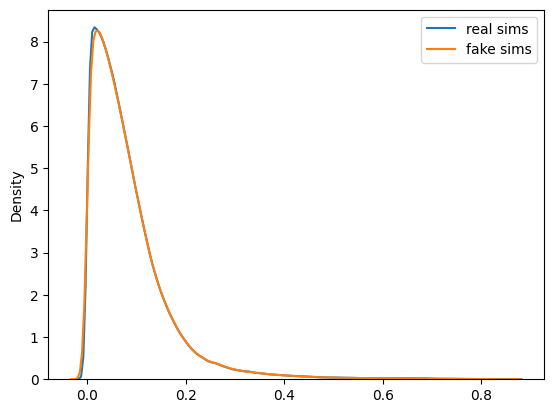

In [ ]:
sns.kdeplot(block_5_sims.flatten(), label="real sims")
sns.kdeplot(fake_sims, label="fake sims")
_ = plt.legend()

Now we'll define functions that perform the actual simulation:

In [ ]:
def run_simulation(
    top_n: int,
    n_subspaces: int,
    reference_sims: torch.Tensor,
    iterations: int,
) -> int:
    # Generate `top_n` random token idxs to stand in for the
    # top_n tokens predicted by the similar strings approximation.
    token_idxs = torch.randperm(tokenizer.vocab_size)[:top_n]

    fake_sims_generator = create_fake_sims_generator(reference_sims)

    count = 0
    for i in range(iterations):
        # Generate fake similarities, to stand in for the real
        # similarities between the ffwd outputs and the token subspaces.
        fake_sims = fake_sims_generator(tokenizer.vocab_size)

        # Sort the fake similarities. The sorted indices are the token indexes
        # for the "most similar" tokens.
        sorted = fake_sims.sort(descending=True)

        # The criteria is satisfied if all token_idxs appear in the first `n_subspaces`
        # elements of the sorted indices (standing in for the token ids for the most
        # similar subspaces).
        if all([token_idx in sorted.indices[:n_subspaces] for token_idx in token_idxs]):
            count += 1

    return count


In [ ]:
def run_multi_simulations(
    top_ns: Iterable[int],
    iteration_sizes: Iterable[int],
    n_subspaces: int,
    reference_sims: torch.Tensor,
):
    """Returns a dict of the form {top_n: {iteration_size: count}}."""
    results = defaultdict(lambda: defaultdict(int))
    for top_n in tqdm(top_ns):
        for iteration_size in iteration_sizes:
            results[top_n][iteration_size] = run_simulation(
                top_n=top_n,
                n_subspaces=n_subspaces,
                reference_sims=reference_sims,
                iterations=iteration_size,
            )

    # Clear all the default factories
    results.default_factory = None
    for v in results.values():
        v.default_factory = None

    return results

In [ ]:
top_ns = [1, 2, 3, 4, 5]
iteration_sizes = range(100, 1000, 25)
n_subspaces=tokenizer.vocab_size // 2
results_block_5 = run_multi_simulations(
    top_ns=top_ns,
    iteration_sizes=iteration_sizes,
    n_subspaces=n_subspaces,
    reference_sims=block_5_sims.flatten(),
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
def plot_results(
    top_ns: Iterable[int],
    iteration_sizes: Iterable[int],
    results: Dict[int, Dict[int, int]],
    title: str = "",
):
    fig, ax = plt.subplots(figsize=(12, 8))
    for top_n in top_ns:
        ax.plot(
            iteration_sizes,
            [results[top_n][iteration_size] / iteration_size for iteration_size in iteration_sizes],
            label=f"top_n = {top_n}",
        )
        line_label = f"1 / {tokenizer.vocab_size // n_subspaces}^{top_n}"
        expected = 1 / ((tokenizer.vocab_size // n_subspaces) ** top_n)
        ax.hlines(
            y=expected,
            xmin=iteration_sizes[0],
            xmax=iteration_sizes[-1],
            colors="grey",
            linestyles="dashed",
        )
        ax.text(
            iteration_sizes[-1] + 10,
            expected,
            line_label,
            verticalalignment="center",
        )

    ax.set_xlabel("Iterations")
    ax.set_ylabel("Fraction Satisfying Criteria")
    ax.set_ylim(0.0, 1.0)
    ax.set_title(title)
    ax.legend()
    return ax

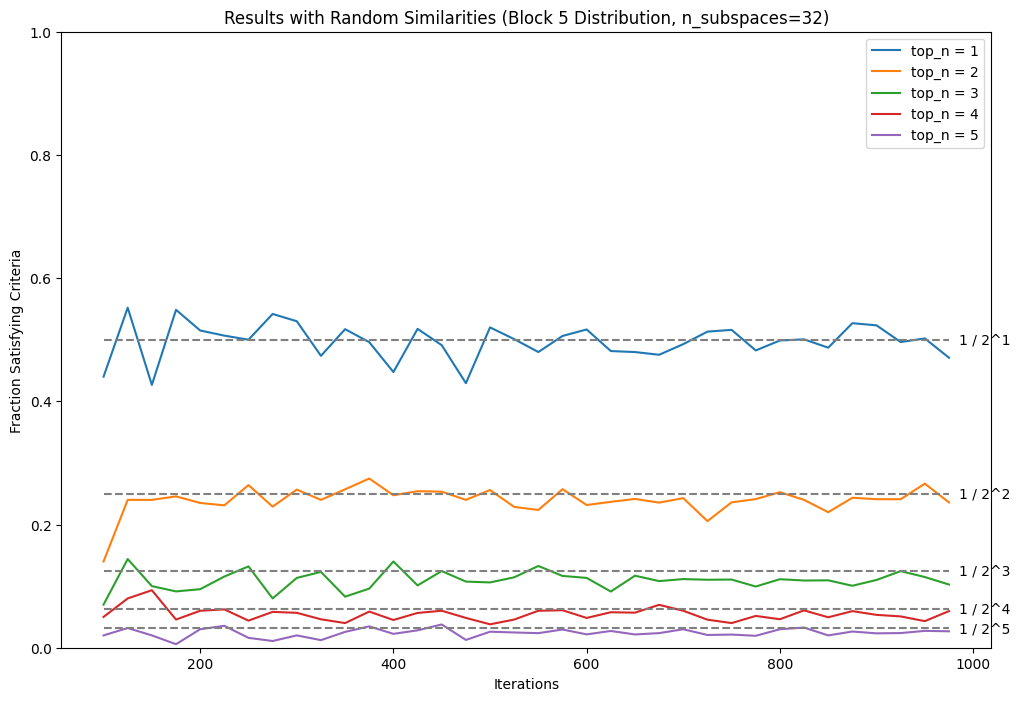

In [ ]:
_ = plot_results(
    top_ns=top_ns,
    iteration_sizes=iteration_sizes,
    results=results_block_5,
    title=f"Results with Random Similarities (Block {block_idx} Distribution, n_subspaces={n_subspaces})",
)

Now let's run it for other blocks:

In [ ]:
block_idx = 4
proj_matrices = block_5_proj_matrices
block_4_sims = compute_all_similarities_to_subspace_projections(
    block_idx=block_idx,
    ffwd_outs=ffwd_outs,
    token_subspace_projection_matrices=proj_matrices,
)
block_4_sims.shape

  0%|          | 0/20000 [00:00<?, ?it/s]

torch.Size([20000, 65])

In [ ]:
top_ns = [1, 2, 3, 4, 5]
iteration_sizes = range(100, 1000, 25)
n_subspaces=tokenizer.vocab_size // 2
results_block_4 = run_multi_simulations(
    top_ns=top_ns,
    iteration_sizes=iteration_sizes,
    n_subspaces=n_subspaces,
    reference_sims=block_4_sims.flatten(),
)

  0%|          | 0/5 [00:00<?, ?it/s]

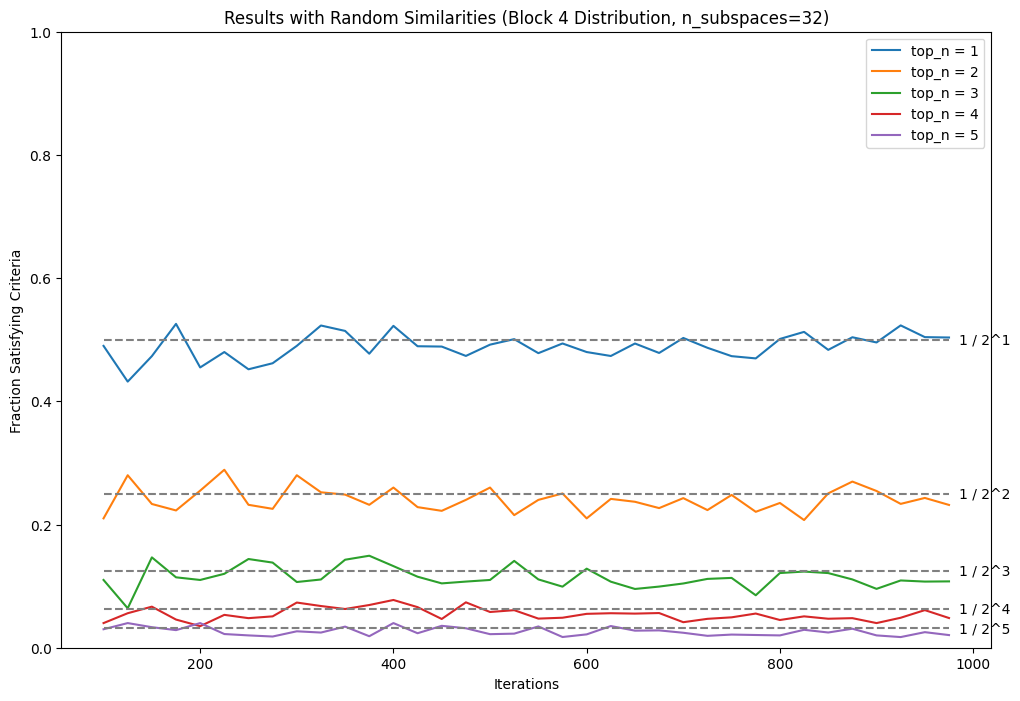

In [ ]:
_ = plot_results(
    top_ns=top_ns,
    iteration_sizes=iteration_sizes,
    results=results_block_4,
    title=f"Results with Random Similarities (Block {block_idx} Distribution, n_subspaces={n_subspaces})",
)

In [ ]:
block_idx = 3
proj_matrices = block_4_proj_matrices
block_3_sims = compute_all_similarities_to_subspace_projections(
    block_idx=block_idx,
    ffwd_outs=ffwd_outs,
    token_subspace_projection_matrices=proj_matrices,
)
block_3_sims.shape

  0%|          | 0/20000 [00:00<?, ?it/s]

torch.Size([20000, 65])

In [ ]:
top_ns = [1, 2, 3, 4, 5]
iteration_sizes = range(100, 1000, 25)
n_subspaces=tokenizer.vocab_size // 2
results_block_3 = run_multi_simulations(
    top_ns=top_ns,
    iteration_sizes=iteration_sizes,
    n_subspaces=n_subspaces,
    reference_sims=block_3_sims.flatten(),
)

  0%|          | 0/5 [00:00<?, ?it/s]

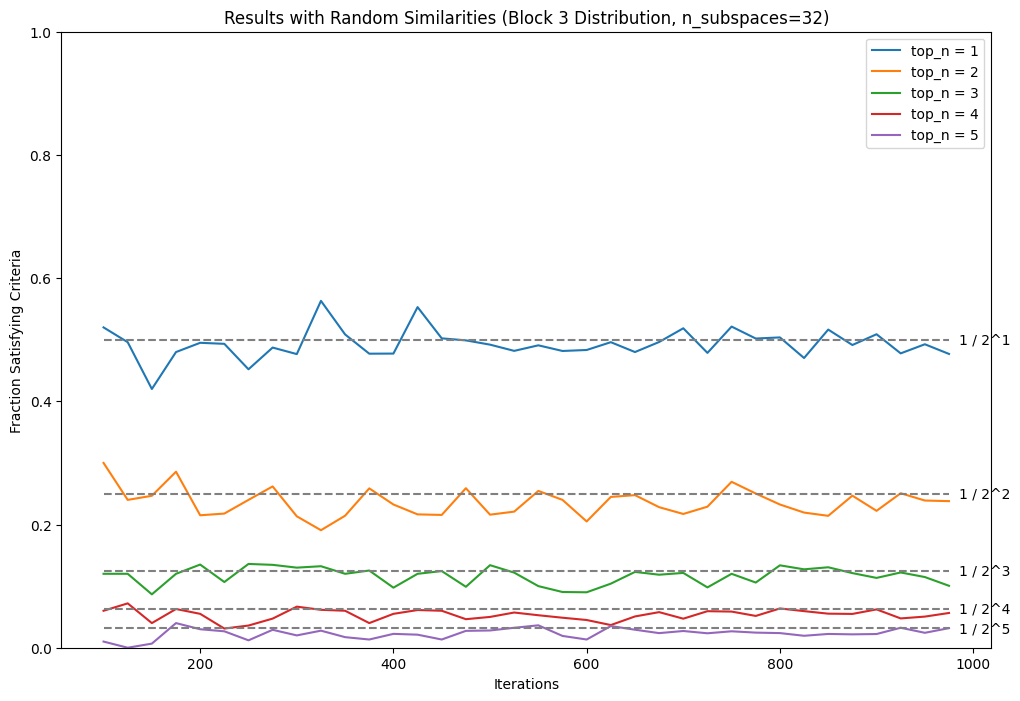

In [ ]:
_ = plot_results(
    top_ns=top_ns,
    iteration_sizes=iteration_sizes,
    results=results_block_3,
    title=f"Results with Random Similarities (Block {block_idx} Distribution, n_subspaces={n_subspaces})",
)

Across all 3 blocks, the results appear quite consistent and close to `1 / ((tokenizer.vocab_size // n_subspaces) ** top_n)`. So for the following `top_n` values, these are roughly the chances of satisfying our criteria:

| `top_n` | Probability from Formula | Simulated Probability |
|-|-|-|
| 1 | 50% | 50.04% ± 1.78% |
| 2 | 25%| 24.18% ± 1.19% |
| 3 | 12.5% | 10.92% ± 0.73% |
| 4 | 6.25% | 5.14% ± 0.70% |
| 5 | 3.12% |2.51% ± 0.43% |

In [ ]:
#| hide
for top_n in [1,2, 3, 4, 5]:
    print(f"{1 / ((tokenizer.vocab_size // n_subspaces) ** top_n):.2%}")

50.00%
25.00%
12.50%
6.25%
3.12%


In [ ]:
#| hide
for top_n in [1, 2, 3, 4, 5]:
    data = torch.tensor([
        results_block_5[top_n][iteration_size] / float(iteration_size)
        for iteration_size in iteration_sizes[-10:]
    ])
    print(f"{data.mean():.2%} ± {data.std():.2%}")

50.04% ± 1.78%
24.18% ± 1.19%
10.92% ± 0.73%
5.14% ± 0.70%
2.51% ± 0.43%


This gives us a sense of the chance of a single query satisfying the criteria given a specific number of tokens considered. But in our calculations of aggregate performance above, each query considered a different number of tokens based on how many were needed to hit the 90% probability mass. So now lets go through and for each block, use the actual number of tokens considered for each query along with the probabilities above to simulate several runs and see what the aggregate results would be.

In [ ]:
def simulate_aggregate_results(
    top_n: int,
    prob_threshold: float,
    approx_probs: List[List[float]],
    simulation_results_for_block: Dict[int, Dict[int, int]],
    iterations: int,
):
    """Based on the number of tokens actually matched for each query, run
    `iterations` simulations using the probabilities of chance success
    computed in the previous simulation. This gives an estimate of the
    expected percentage of queries that will satisfy the criteria if
    it was all chance."""

    # Get the probabilities from the earlier simulation results
    ns = [1, 2, 3, 4, 5]
    probs = torch.zeros(len(ns), dtype=torch.float32)
    for n in ns:
        probs[n-1] = torch.tensor([
            simulation_results_for_block[n][iteration_size] / float(iteration_size)
            for iteration_size in iteration_sizes[-10:]
        ]).mean()

    # Get the number of tokens needed to cover `prob_threshold` probability mass
    # using the same criteria as the main evaluation.
    n_tokens = torch.zeros(n_prompts, dtype=torch.long)
    for i in range(n_prompts):
        n_tokens[i] = min(
            approx_probs[i].shape[0] - (approx_probs[i].cumsum(dim=0) > prob_threshold).sum() + 1,
            min(approx_probs[i].shape[0], top_n)
        )

    # Create a tensor to hold the counts for each iteration
    counts = torch.zeros(iterations, dtype=torch.float32)

    for it in tqdm(range(iterations)):
        count = 0
        for i in range(n_prompts):
            n = n_tokens[i] # How many tokens used for this prompt
            target_probs = probs[n-1] # What's the probability of a chance right answer with this many tokens
            if torch.rand(1) < target_probs:
                count += 1
        counts[it] = count

    return counts / n_prompts



In [ ]:
block_idx = 5
torch.manual_seed(1442)
agg_sim_results_block_5 = simulate_aggregate_results(
    top_n=5,
    prob_threshold=0.90,
    approx_probs=per_block_data[block_idx]["approx_probs"],
    simulation_results_for_block=results_block_5,
    iterations=1000,
)

In [ ]:
print(f"For block {block_idx}, {agg_sim_results_block_5.mean():.2%} ± {agg_sim_results_block_5.std():.2%} of queries that would satisfy the criteria if it was all chance.")

For block 3, 21.78% ± 0.27% of queries that would satisfy the criteria if it was all chance.


In [ ]:
block_idx = 4
torch.manual_seed(1442)
agg_sim_results_block_4 = simulate_aggregate_results(
    top_n=5,
    prob_threshold=0.90,
    approx_probs=per_block_data[block_idx]["approx_probs"],
    simulation_results_for_block=results_block_4,
    iterations=1000,
)

In [ ]:
print(f"For block {block_idx}, {agg_sim_results_block_4.mean():.2%} ± {agg_sim_results_block_4.std():.2%} of queries that would satisfy the criteria if it was all chance.")

For block 3, 20.56% ± 0.26% of queries that would satisfy the criteria if it was all chance.


In [ ]:
block_idx = 3
torch.manual_seed(1442)
agg_sim_results_block_3 = simulate_aggregate_results(
    top_n=5,
    prob_threshold=0.90,
    approx_probs=per_block_data[block_idx]["approx_probs"],
    simulation_results_for_block=results_block_3,
    iterations=1000,
)

In [ ]:
print(f"For block {block_idx}, {agg_sim_results_block_3.mean():.2%} ± {agg_sim_results_block_3.std():.2%} of queries that would satisfy the criteria if it was all chance.")

For block 3, 18.94% ± 0.25% of queries that would satisfy the criteria if it was all chance.
